In [9]:
import sys
import artm

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from tqdm import tqdm

sys.path.append('../src')
from topic_modeling import *

In [2]:
batches_path = '../data/interim/batches'

dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

batch_vectorizer = artm.BatchVectorizer(data_path=batches_path, data_format='batches')

articles = pd.read_csv('../data/interim/articles_preproc.csv')
labels_true = articles[['id', 'hr_level_0']]

In [3]:
def metrics_visualisation(scores):
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    
    for index, (score_name, model_scores) in enumerate(scores.items()):
        
        i = index % 3
        j = index % 2
        
        model_scores = pd.DataFrame(model_scores)
        
        x = model_scores.index.values
        
        for model_name in model_scores.columns:
            
            y = model_scores.loc[:, model_name]
            axes[i, j].plot(x, y, label=model_name)
            
        axes[i, j].set_ylabel(score_name)
        axes[i, j].legend()
    
    fig.tight_layout()

100%|██████████| 50/50 [00:59<00:00,  1.21s/it]


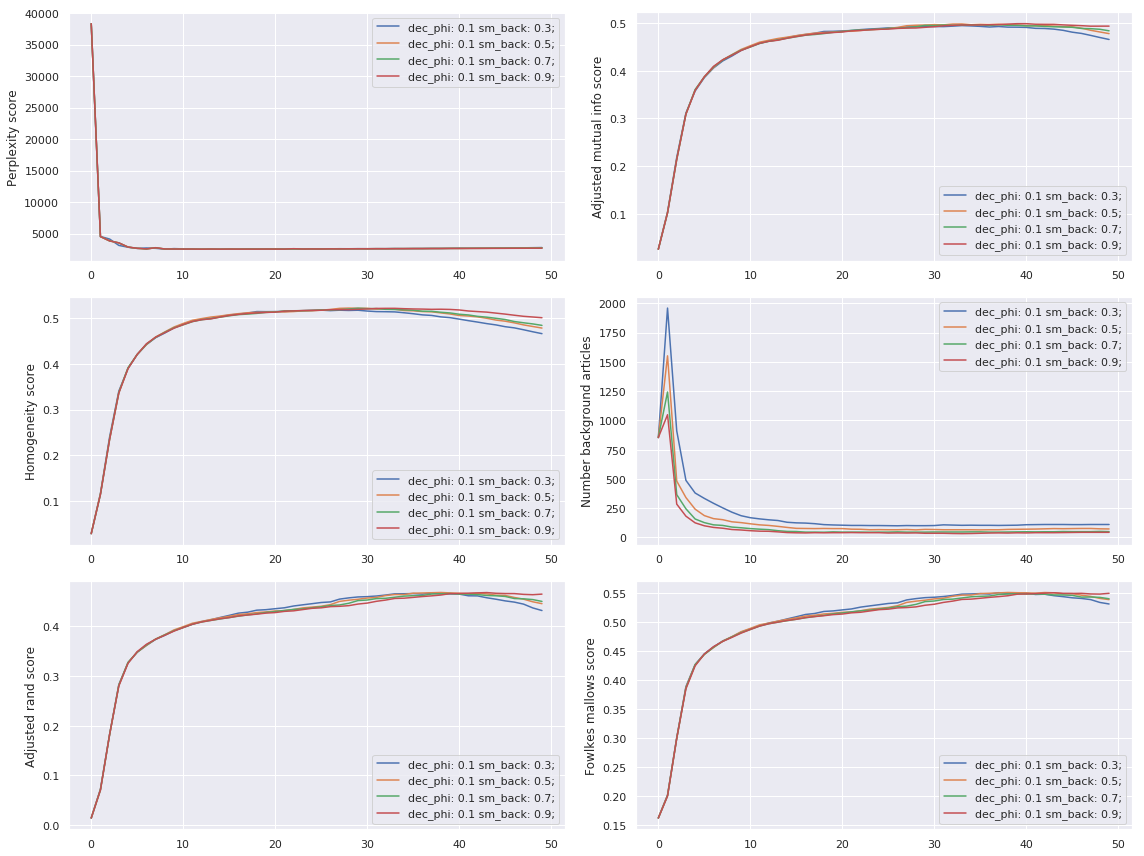

In [4]:
num_topics = 9
num_collection_passes = 50

scores = {'Perplexity score': {},
              'Number background articles': {},
              'Adjusted rand score': {},
              'Adjusted mutual info score': {},
              'Homogeneity score': {}, 
              'Fowlkes mallows score': {}}

for smooth_background_tau in np.arange(0.3, 1, 0.2):
    
    model_name = f'dec_phi: 0.1'
    model_name += f' sm_back: {smooth_background_tau:.1f};'
        
    topic_model = TopicModeling(dictionary, num_topics=num_topics, 
                                num_collection_passes=1,
                                smooth_background_tau=smooth_background_tau, 
                                sparse_phi_tau=0, decorrelator_phi_tau=0.1)

    for epoch in tqdm(range(num_collection_passes)):

        labels_pred = topic_model.fit_predict(batch_vectorizer)

        n_background_articles = len(get_background_articles(articles, labels_pred))
        if (n_background_articles == len(articles)): break

        scores['Number background articles'].setdefault(model_name, [])
        scores['Number background articles'][model_name].append(n_background_articles)

        perplexity_score = topic_model.model.score_tracker['perplexity'].last_value

        scores['Perplexity score'].setdefault(model_name, [])
        scores['Perplexity score'][model_name].append(perplexity_score)

        adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, fowlkes_mallows_score = get_metrics(labels_true, labels_pred)

        scores['Adjusted rand score'].setdefault(model_name, [])
        scores['Adjusted rand score'][model_name].append(adjusted_rand_score)

        scores['Adjusted mutual info score'].setdefault(model_name, [])
        scores['Adjusted mutual info score'][model_name].append(adjusted_mutual_info_score)

        scores['Homogeneity score'].setdefault(model_name, [])
        scores['Homogeneity score'][model_name].append(homogeneity_score)

        scores['Fowlkes mallows score'].setdefault(model_name, [])
        scores['Fowlkes mallows score'][model_name].append(fowlkes_mallows_score)
                
metrics_visualisation(scores)
plt.show()

In [4]:
topic_model = TopicModeling(dictionary, num_topics=9, num_collection_passes=50,
                            smooth_background_tau=0.9, sparse_phi_tau=0, decorrelator_phi_tau=0.1)

labels_pred = topic_model.fit_predict(batch_vectorizer)

In [5]:
for topic_name, title_top_tokens in topic_model.model.score_tracker['title_top_tokens'].last_tokens.items():
    
    print(topic_name.upper())
    print('TITLE: '+', '.join(title_top_tokens))
    
    text_top_tokens = topic_model.model.score_tracker['text_top_tokens'].last_tokens[topic_name]
    print('TEXT: '+', '.join(text_top_tokens))
    
    topic_labels_pred = labels_pred[labels_pred == topic_name]
    print(f'TOPIC SIZE: {len(topic_labels_pred)}')
    
    topic_ids = topic_labels_pred.index.astype(int)
    corresponding_topics = articles[articles.id.isin(topic_ids)].groupby('hr_level_0').id.count().sort_values(ascending=False)
    print(f'CORRESPONDING TOPIC: {corresponding_topics.index[0]}')
    print('; '.join([f'{name} - {value}' for name, value in zip(corresponding_topics.index, corresponding_topics.values)]))
    
    print()

TOPIC_0
TITLE: северный, суд, автобус, германий, нафтогаз, савченко, поставка, строительство, газпром, польша, корабль, учение, самолёт, задержать, долг, теракт, сербия, атака, полёт, патриот, техника, ракетный, шойгу, стрельба, боевой, поток, аэропорт, истребитель, израиль, сентябрь, фрг, комплекс, надежда, берлина, испытание, противник, угроза, лукашенко, разрешение, подписать, парад, саудовский, аравия, адвокат, америка, атаковать, котик, неисправный, нетаньяха, арктика, условный, смешарик, беспилотный, убер, сало, россельхознадзор, разведка, офис, море, урал, учитель, поставить, аризона, бондарчук, рвсна, флот, авиация, косово, боеинга, выдать, взорвать, остановить, потоку-2, военно-морской, белоруссия, цель, обжаловать, партия, ярс, отразить, воздушный, премьер-министр, белорусский, военнослужащий, небо, нога, полюс, wанна, цры, саркози, форум, калининградский, наехать, домогательство, зрк, рейс, вертолёт, туристический, пилот, беспилотник
TEXT: северный, строительство, комплекс, 

In [6]:
articles.hr_level_0.drop_duplicates()

0               Авто
516            Спорт
545         Политика
3590        Общество
3734        Культура
3793    Происшествия
4142      Технологии
4946       Экономика
9654           Наука
Name: hr_level_0, dtype: object

Даже на первом уровне очень плохо отделяются темы

Идея: Выделять имена персонажей и использовать их в качестве модальности при этом удаляя их из текстов, что бы токены не поподали в основные модальности

Выделение именованных сущностей: 
* https://ru.bmstu.wiki/NER_(Named-Entity_Recognition)
* https://habr.com/ru/company/mailru/blog/354456/
* http://ceur-ws.org/Vol-1743/paper18.pdf
* https://polyglot.readthedocs.io/en/latest/NamedEntityRecognition.html
* https://github.com/deepmipt/ner
* http://www.dialog-21.ru/media/3807/sysoev.pdf